In [370]:
# Standard library imports
import sys
from datetime import datetime
from time import process_time
pt0 = process_time()
from time import time as wall_clock
wc0 = wall_clock()

# Third-Party Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy

import xarray

# Local imports
import pystare

# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
# PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6


n_legend_colors = 8
LEGEND_COLORS = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))

# 10 Colors
# LEGEND_COLORS = list(mcolors.TABLEAU_COLORS)

# 8 Colors
# LEGEND_COLORS = list(mcolors.BASE_COLORS)

# 148 Colors
#LEGEND_COLORS = list(mcolors.CSS4_COLORS)

# 949 Colors
# LEGEND_COLORS = list(mcolors.XKCD_COLORS)

# Define Classes and Functions
# ----------------------------

def divert_stderr():
    sys.stderr = open('stderr.out', 'w')
    return


def restore_stderr(_verbose=None):
    _verbose = (True if _verbose is None else _verbose)
    sys.stderr.close()
    if _verbose:
        with open('stderr.out') as f:
            count = sum(1 for _ in f)
        if count > 0:
            print(f"{count} warnings or errors encountered while stderr diverted. See stderr.out")
    sys.stderr = sys.__stderr__
    return


class FigAxContainer:
    def __init__(self, figax):
        self.fig = figax[0]  # class 'matplotlib.figure.Figure'
        self.ax = figax[1]   # class 'cartopy.mpl.geoaxes.GeoAxesSubplot'
        return


def add_coastlines(figax, set_global=None):
    """Add coastlines to the plot."""
    set_global = (False if set_global is None else set_global)
    if set_global:
        figax.ax.set_global()
    figax.ax.add_feature(cf.COASTLINE, linewidth=0.5, edgecolor='k')
    return figax


def hello_plot(spatial_index_values=None
               , figax=None, plot_options=None, set_global=None, set_coastlines=None
               , show_fig=None, color=None, lw=None, legend_label=None, use_dash=None
               , bbox_to_anchor=None
               , verbose=None
               , rasterized=None
              ):
    
    spatial_index_values = (None if spatial_index_values is None else spatial_index_values)
    figax = (None if figax is None else figax)
    plot_options = ({'projection': ccrs.PlateCarree()
                     , 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    set_global = (False if set_global is None else set_global)
    set_coastlines = (True if set_coastlines is None else set_coastlines)
    show_fig = (True if show_fig is None else show_fig)
    color = (None if color is None else color)
    lw = (1 if lw is None else lw)
    legend_label = (None if legend_label is None else legend_label)
    use_dash = (None if use_dash is None else use_dash)
    bbox_to_anchor = (None if bbox_to_anchor is None else bbox_to_anchor)
    verbose = (True if verbose is None else verbose)
    rasterized = (True if rasterized is None else rasterized)

    if figax is None:
        # Initialize the FigAxContainer the first time it is used
        figax = FigAxContainer(plt.subplots(1, subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()

    if spatial_index_values is not None:
        if isinstance(spatial_index_values,xarray.Dataset):
            lons = spatial_index_values.lons.data.reshape(3*len(spatial_index_values.htm))
            lats = spatial_index_values.lats.data.reshape(3*len(spatial_index_values.htm))
            intmat = spatial_index_values.intmat.data
        else:
            # Calculate vertices and interconnection matrix
            lons, lats, intmat = pystare.triangulate_indices(spatial_index_values)

        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons, lats, intmat)

        divert_stderr()
        if use_dash is not None:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw,
                             label="Placeholder", dashes=use_dash, rasterized=rasterized)            
        else:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw, 
                             label="Placeholder", rasterized=rasterized)
        restore_stderr(_verbose=verbose)
 
        # Add Legend
        if legend_label is not None:
            if isinstance(legend_label, list):
                # plt.triplot produces two legend entries. 
                #  The first of those are the edges
                #  The second contains the points (nodes).
                bbox_to_anchor = ( (1.7,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                the_handels, the_labels = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=the_handels[::2], labels=legend_label, bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False) 
            elif isinstance(legend_label, str):
                bbox_to_anchor = ( (1.4,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                h, l = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=[h[0]], labels=[legend_label], bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False)

    if show_fig:
        # Show figure now
        plt.show()

    return figax

def hex16(ival):
    return "0x%016x" % ival

def labeled_plot(sivs,figax,plot_labels=True
                 , bbox_to_anchor=None
                 , plot_options=None
                 , rasterized = None
                ):
    bbox_to_anchor = (None if bbox_to_anchor is None else bbox_to_anchor)
    plot_options = ({'projection': ccrs.PlateCarree()
                     , 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    rasterized = ( True if rasterized is None else rasterized )
    
    # Plot each increment (overlay on common axes)
    legend_info = []
    n_legend_colors = len(sivs)
    legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
    
    for siv_idx, siv in enumerate(sivs):
        
        legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
        the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
        the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
        if len(legend_info[0]) < 32 or not plot_labels:
            hello_plot(spatial_index_values=[siv], figax=figax, plot_options=plot_options
                       , bbox_to_anchor=bbox_to_anchor
                       , color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash
                       , verbose=False
                       , rasterized=rasterized
                      )
        else:
            hello_plot(spatial_index_values=[siv], figax=figax, plot_options=plot_options
                       , bbox_to_anchor=bbox_to_anchor
                       , color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False
                       , lw=the_lw, use_dash=the_dash
                       , verbose=False
                       , rasterized=rasterized
                      )
            


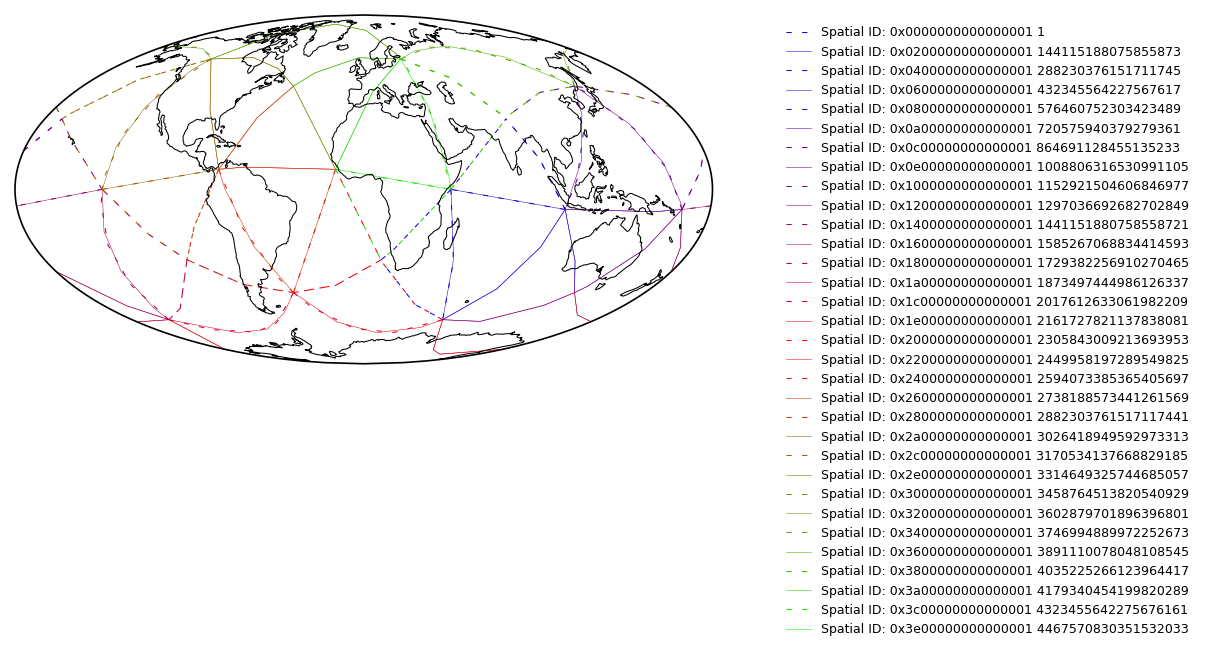

In [254]:
level = 1
level_increment = pystare.spatial_increment_from_level(level)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

# Plot each increment (overlay on common axes)
legend_info = []
n_legend_colors = 8*(4**level)+1
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
    for siv_idx, siv in enumerate(range(0, (8 * (4**level)) * level_increment, level_increment)):
    siv = siv + level # Set the level
    # print(siv_idx,siv)
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
    the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
    if len(legend_info[0]) < 32:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax

In [383]:
def make_stare_htm_info_at_level(level=None,dask=None):
    "Make an xarray with all of the STARE htm-ids at a level, including vertex info."
    level = ( 1 if level is None else level )
    dask  = ( 'allowed' if dask is None else dask )
    level_increment = pystare.spatial_increment_from_level(level)
    n_trixels       = 8 * (4 ** level)
    r_              = numpy.arange(n_trixels)
    r_trixels       = r_ * level_increment+level
    htm = xarray.DataArray(r_, dims=("htm"),coords={"htm": r_trixels})

    data1 = xarray.apply_ufunc(
        pystare.triangulate_indices
        ,htm.htm
        ,input_core_dims=[["htm"]]
        ,dask=dask
    )

    lons = xarray.DataArray(data1.data[()][0].reshape(len(htm),3),dims=("htm","vertex"),coords={"htm": r_trixels})
    lats = xarray.DataArray(data1.data[()][1].reshape(len(htm),3),dims=("htm","vertex"),coords={"htm": r_trixels})
    intmat = xarray.DataArray(data1.data[()][2],dims=("htm","vertex"),coords={"htm": r_trixels})


    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d-%H:%M:%S")
    
    return xarray.Dataset(
        {
            "lons":    lons
            ,"lats":   lats
            ,"intmat":intmat
        }
        ,attrs = {
            "creator"   : "make_stare_htm_info_at_level v1"
            ,"level"    : level
            ,"datetime" : dt_string
        }
    )

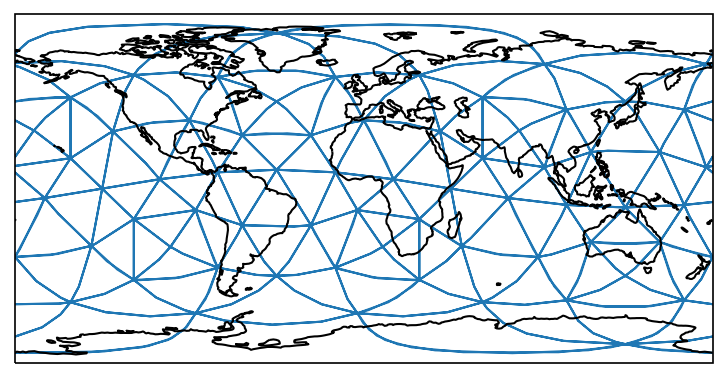

In [256]:
hello_plot(make_stare_htm_info_at_level(2))

In [257]:
htm_2 = make_stare_htm_info_at_level(2)

In [258]:

htm_2


<xarray.Dataset>
Dimensions:  (htm: 128, vertex: 3)
Coordinates:
  * htm      (htm) int64 2 36028797018963970 ... 4575657221408423938
Dimensions without coordinates: vertex
Data variables:
    lons     (htm, vertex) float64 9.736 28.68 28.68 61.32 ... 39.42 0.0 15.36
    lats     (htm, vertex) float64 -30.0 -47.1 -15.7 -58.6 ... 29.52 35.26 4.85
    intmat   (htm, vertex) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Attributes:
    creator:   make_stare_htm_info_at_level v1
    level:     2
    datetime:  2020-11-06-19:43:55

In [262]:
htm_2.to_netcdf('htm_2.nc4')

In [260]:
! ls -l htm_2.nc4

-rw-r--r--@ 1 mrilee  staff  19099 Nov  6 19:10 htm_2.nc4


In [261]:
! rm htm_2.nc4

In [241]:
! open htm_2.nc4

In [263]:
htm_check = xarray.open_dataset('htm_2.nc4')

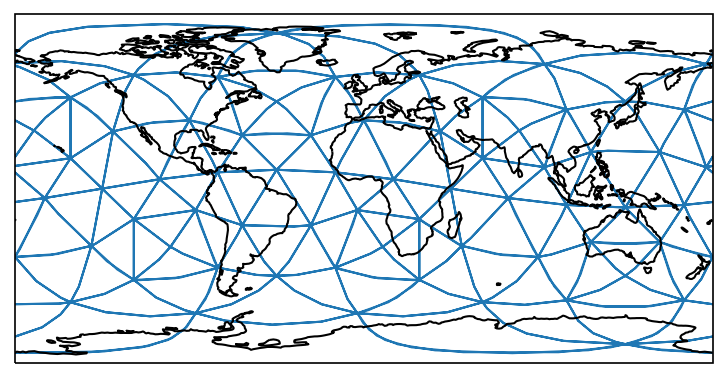

htm_check: Made by "make_stare_htm_info_at_level v1" at "2020-11-06-19:09:16"


In [264]:
hello_plot(htm_check)
print('htm_check: Made by "%s" at "%s"'%(htm_check.creator,htm_check.datetime))

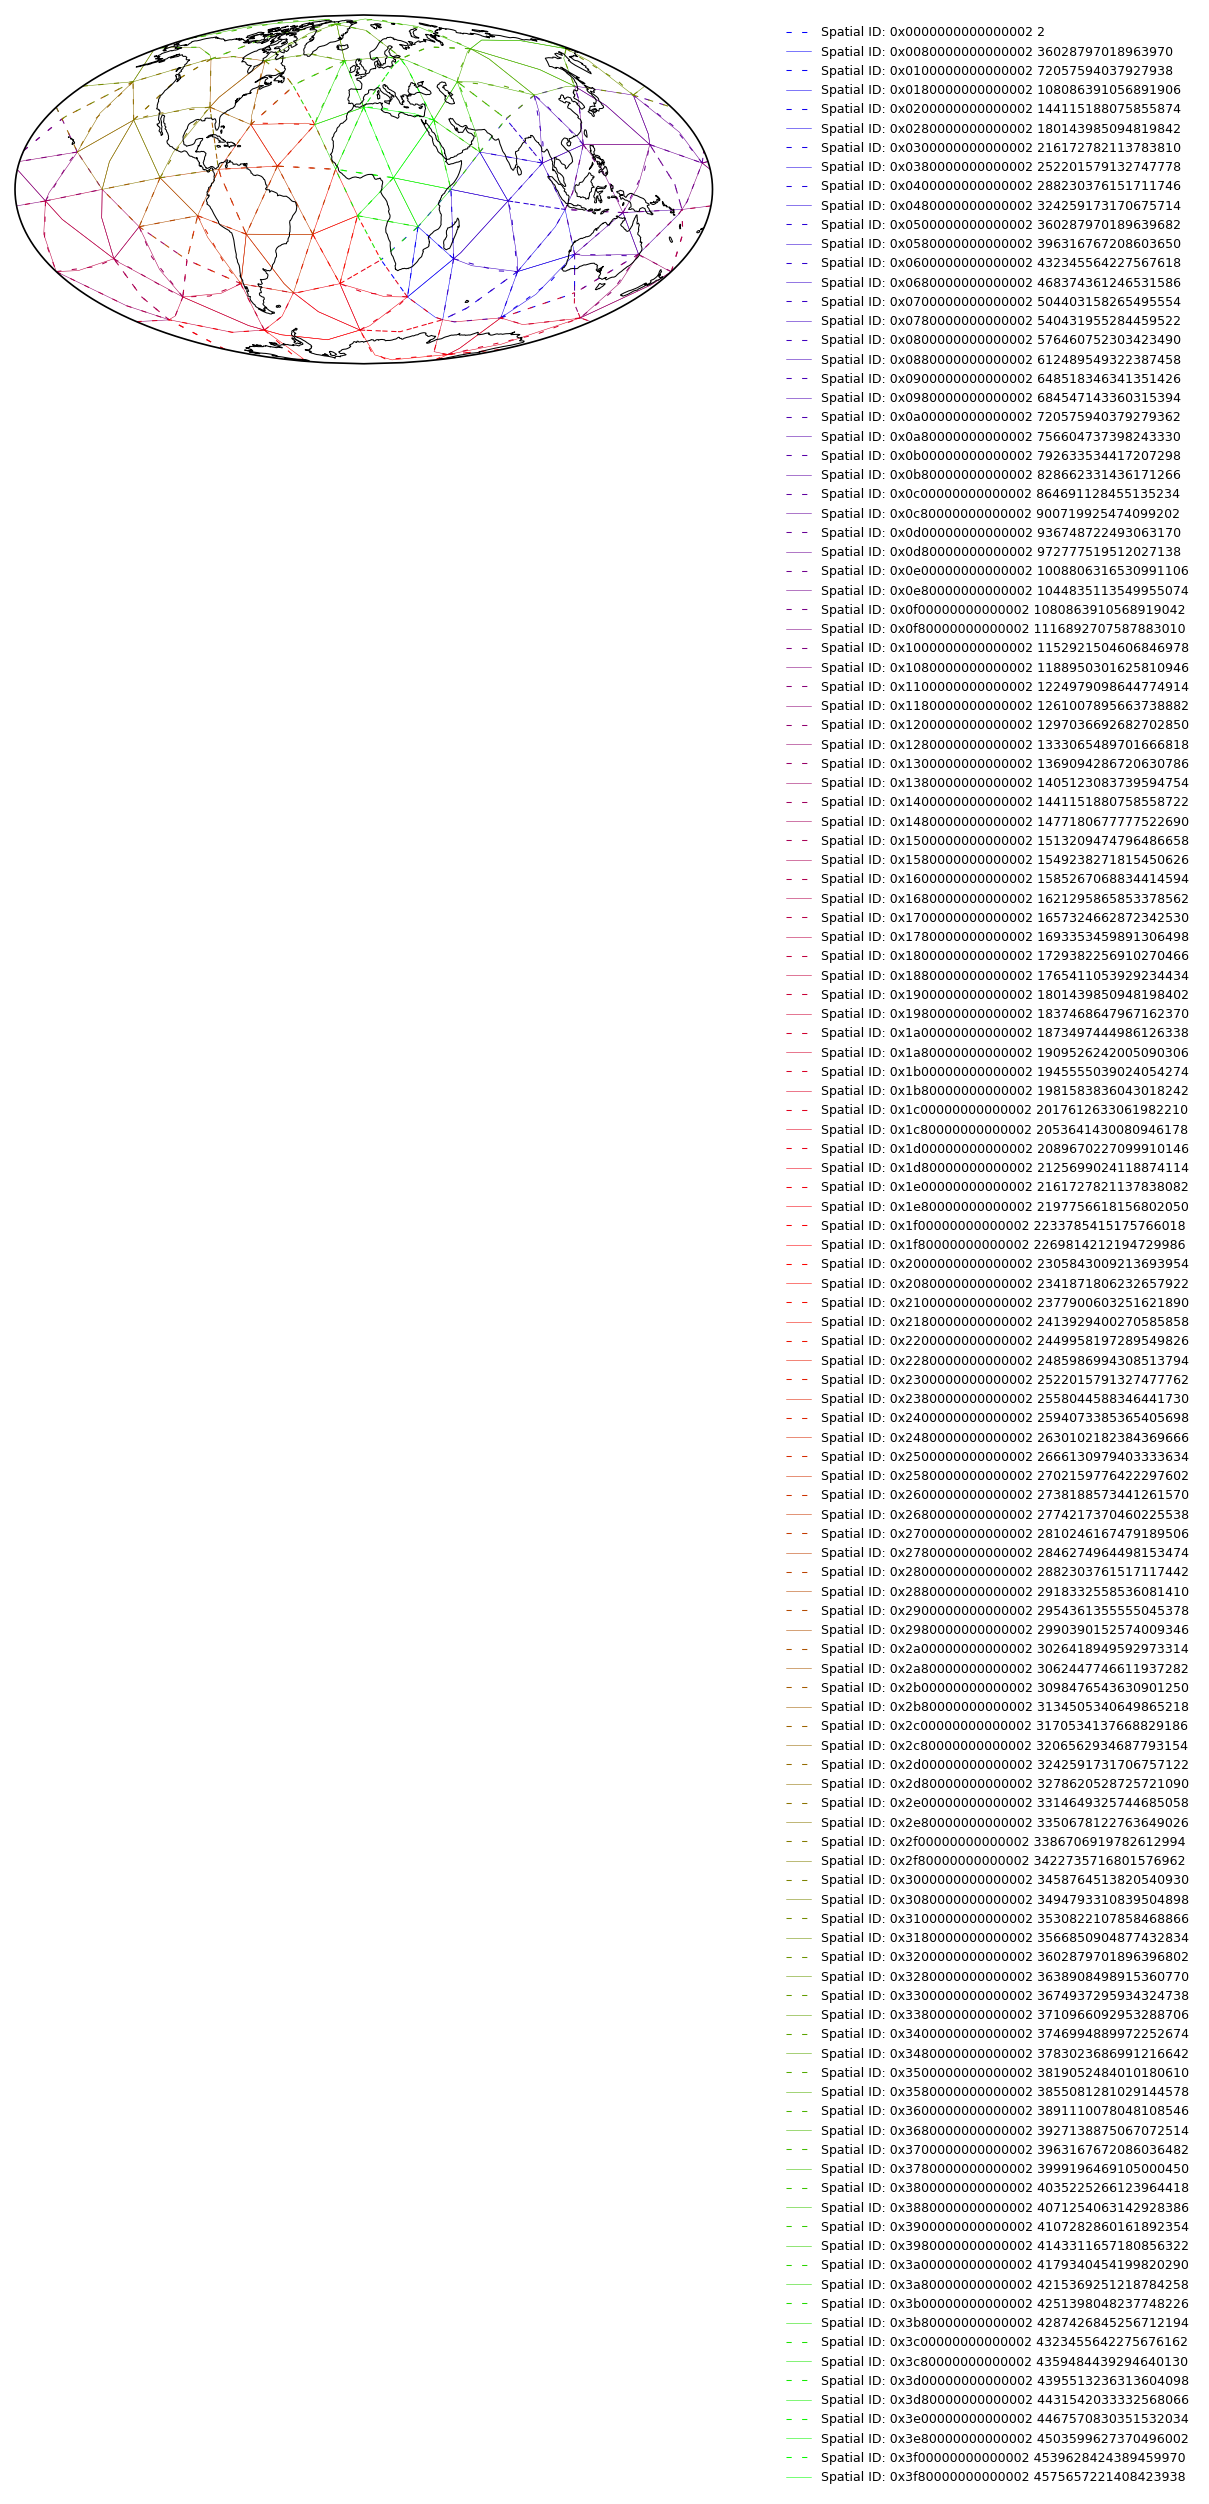

In [265]:
# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

labeled_plot(htm_check.htm.data,usr_figax)
    
plt.show()
plt.close('all')
del usr_figax

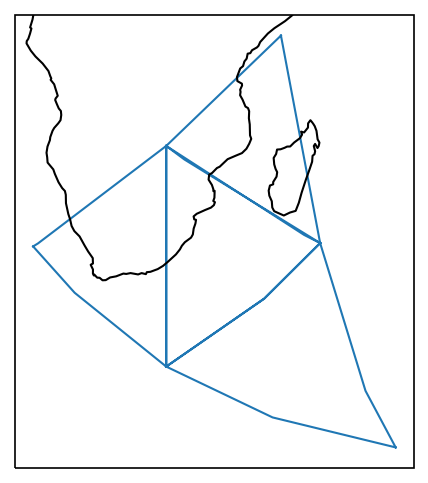

In [280]:
hello_plot(htm_check.isel(htm=[0,1,2,3]))

In [411]:
htm_check = xarray.open_dataset('htm-11.nc')

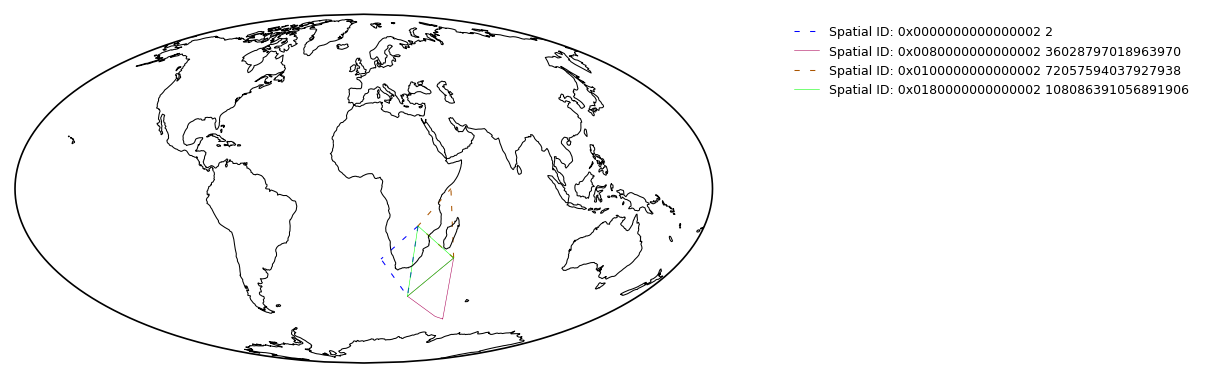

In [371]:
# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

labeled_plot(htm_check.isel(htm=[0,1,2,3]).htm.data,usr_figax)
    
plt.show()
plt.close('all')
del usr_figax

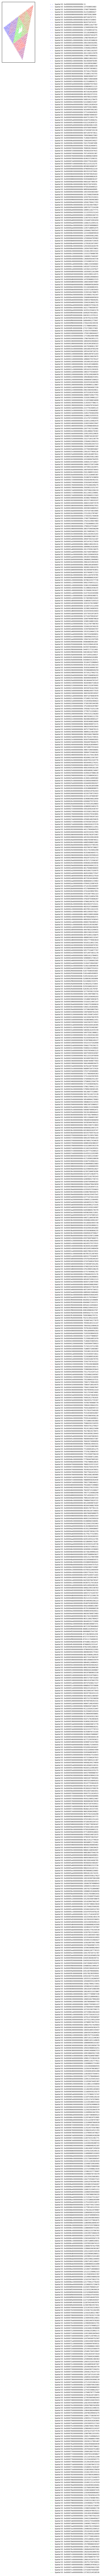

In [416]:
# usr_plot_options = {'projection': PROJ, 'transform': TRANSF}

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=False
                                      , show_fig=False
                                      , plot_options=usr_plot_options))

# labeled_plot(htm_check.isel(htm=[0,1,2,3]).htm.data
labeled_plot(htm_check.isel(htm=list(range(1000))).htm.data
             , usr_figax
             , bbox_to_anchor=(3.0,1.0)
             , plot_options = {'projection': ccrs.Mollweide(), 'transform': ccrs.Geodetic()}
             , rasterized = True
            )
    
plt.show()
plt.close('all')
del usr_figax

In [404]:
# ! rm /Users/mrilee/git/STARE-Cookbooks/contrib/jupyter/htm-3.nc
! du -sm *htm*.nc | sort -rn

2561	htm-11.nc
641	htm-10.nc
177	tmp-htm-11.nc
162	tmp-htm-10.nc
161	htm-9.nc
41	tmp-htm-9.nc
41	htm-8.nc
41	htm-08.nc
11	htm-7.nc
11	htm-07.nc
10	tmp-htm-8.nc
3	tmp-htm-7.nc
3	htm-6.nc
3	htm-06.nc
1	tmp-htm-6.nc
1	tmp-htm-5.nc
1	tmp-htm-4.nc
1	tmp-htm-3.nc
1	tmp-htm-2.nc
1	htm-5.nc
1	htm-4.nc
1	htm-3.nc
1	htm-2.nc
1	htm-05.nc
1	htm-04.nc
1	htm-02.nc


In [384]:
timings=[]

In [410]:
pc_a = process_time()
level = 1
htm = make_stare_htm_info_at_level(level,dask=True)
htm_fname = 'htm-%02i.nc'%(level)
htm.to_netcdf(htm_fname)
# hello_plot(htm)
timings.append((level,process_time()-pc_a))
print('p-timing: ',timings[-1])

p-timing:  (1, 0.02132500000152504)


In [401]:
timings

[(2, 0.4682599999996455),
 (2, 0.03145499999845924),
 (4, 0.16480699999920034),
 (5, 1.6628209999998944),
 (6, 7.107705000000351),
 (7, 27.562949999999546),
 (8, 108.88581199999862)]

In [394]:
! ls -l *.nc

-rw-r--r--  1 mrilee  staff       19099 Nov 10 09:13 htm-02.nc
-rw-r--r--  1 mrilee  staff      171675 Nov 10 09:14 htm-04.nc
-rw-r--r--  1 mrilee  staff   671096475 Nov  9 17:13 htm-10.nc
-rw-r--r--  1 mrilee  staff  2684362395 Nov  9 19:59 htm-11.nc
-rw-r--r--  1 mrilee  staff       19099 Nov  9 16:29 htm-2.nc
-rw-r--r--  1 mrilee  staff       48795 Nov  6 22:30 htm-3.nc
-rw-r--r--  1 mrilee  staff      171675 Nov  6 22:30 htm-4.nc
-rw-r--r--  1 mrilee  staff      663195 Nov  6 22:31 htm-5.nc
-rw-r--r--  1 mrilee  staff     2629275 Nov  6 22:31 htm-6.nc
-rw-r--r--  1 mrilee  staff    10493595 Nov  9 13:58 htm-7.nc
-rw-r--r--  1 mrilee  staff    41950875 Nov  9 16:05 htm-8.nc
-rw-r--r--  1 mrilee  staff   167779995 Nov  9 16:36 htm-9.nc
-rw-r--r--  1 mrilee  staff   167373306 Nov  9 18:19 tmp-htm-10.nc
-rw-r--r--  1 mrilee  staff   111678585 Nov 10 09:14 tmp-htm-11.nc
-rw-r--r--  1 mrilee  staff       20277 Nov  9 18:19 tmp-htm-2.nc
-rw-r--r--  1 mrilee  staff       26867 Nov  9 18:19

In [391]:
! rm htm-\ 2.nc

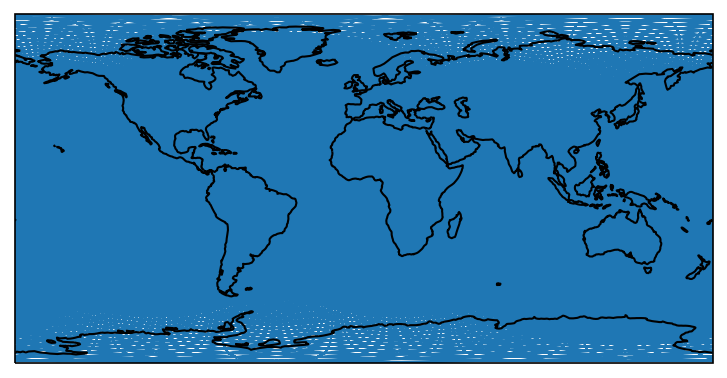

p-timing:  22.174924000000004


In [298]:
pc_a = process_time()
htm_check = xarray.open_dataset(htm_fname)
hello_plot(htm_check)
print('p-timing: ',process_time()-pc_a)

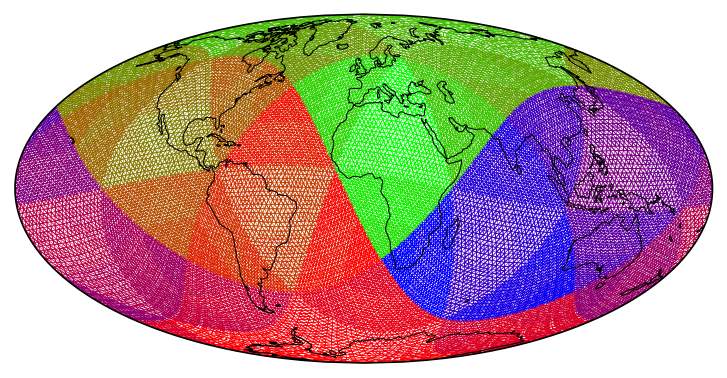

In [300]:
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

labeled_plot(htm_check.htm.data,usr_figax,plot_labels=False)
    
plt.show()
plt.close('all')
del usr_figax

In [301]:
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

n_legend_colors = 8*(4**level)+1
legend_colors_idx = numpy.linspace(0, 1, n_legend_colors)
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))

hello_plot(spatial_index_values=htm_check, figax=usr_figax, plot_options=usr_plot_options, 
            color=legend_colors, show_fig=False, verbose=False)

plt.show()
plt.close('all')
del usr_figax

ValueError: RGBA sequence should have length 3 or 4

<Figure size 900x600 with 1 Axes>

In [309]:
del usr_figax

NameError: name 'usr_figax' is not defined

In [330]:
from matplotlib.colors import ListedColormap

In [339]:
!ls htm*

htm-3.nc  htm-4.nc  htm-5.nc  htm-6.nc  htm_2.nc4


In [345]:
htm_check = xarray.open_dataset('htm-5.nc')

In [376]:
# htm_check.var
# htm_check.dims

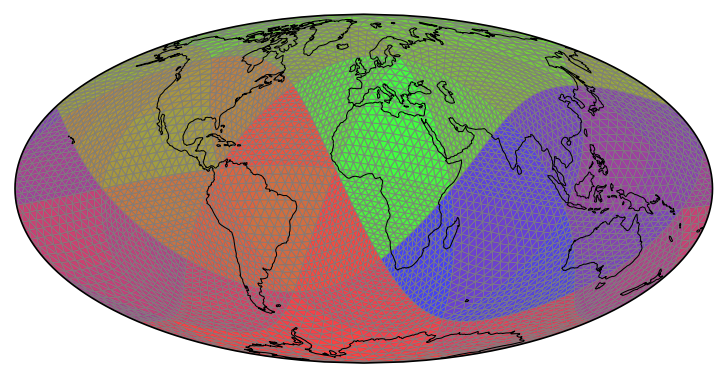

In [349]:
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

vmin=0;vmax=1
n_legend_colors = 8*(4**htm_check.level)
legend_colors_idx = numpy.linspace(0, 1, n_legend_colors)
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
cmap = ListedColormap(legend_colors)

triang = tri.Triangulation(htm_check.lons.data.flatten(),htm_check.lats.data.flatten(),htm_check.intmat.data)
usr_figax.ax.tripcolor(triang
    ,facecolors=legend_colors_idx
    ,edgecolors='grey'
    ,lw=0.5
    ,shading='flat'
    ,vmin=vmin,vmax=vmax
    ,cmap=cmap
    ,alpha=0.75
    ,transform=TRANSF
    ,rasterized=True
)
plt.show()
plt.close('all')
del usr_figax

In [333]:
htm_check.level

6

In [322]:
len(htm_check.lats.data.flatten())

98304

In [324]:
htm_check.intmat.data.shape

(32768, 3)